<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/Team_11_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import glob

In [2]:
!pip -qq install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

     |████████████████████████████████| 234 kB 24.4 MB/s 
     |████████████████████████████████| 177 kB 77.7 MB/s 
     |████████████████████████████████| 53.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 75.2 MB/s 
     |████████████████████████████████| 125 kB 71.7 MB/s 
     |████████████████████████████████| 150 kB 74.4 MB/s 
     |████████████████████████████████| 2.6 MB 59.0 MB/s 
     |████████████████████████████████| 153 kB 67.3 MB/s 
     |████████████████████████████████| 952 kB 59.1 MB/s 
     |████████████████████████████████| 197 kB 84.7 MB/s 
     |████████████████████████████████| 91.7 MB 136 kB/s 
     |████████████████████████████████| 448 kB 68.5 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 62.1 MB/s 
     |████████████████████████████████| 271 kB 72.4 MB/s 
     |████████████████████████████████| 3.6 MB 58.7 MB/s 
     |████████████████████████████████| 2.6 MB 66.0 MB/s 
     |██████████

In [4]:
import datetime
import os
from finrl import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FinRL-Library")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

In [ ]:
pd.options.display.max_rows = 25
pd.options.display.max_columns = 25

In [6]:
path = '/content/ind_nifty50list.csv'
df_stocks = pd.read_csv(path).fillna(0)

In [ ]:
df_stocks.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,Services,ADANIPORTS,EQ,INE742F01042
1,Apollo Hospitals Enterprise Ltd.,Healthcare,APOLLOHOSP,EQ,INE437A01024
2,Asian Paints Ltd.,Consumer Durables,ASIANPAINT,EQ,INE021A01026
3,Axis Bank Ltd.,Financial Services,AXISBANK,EQ,INE238A01034
4,Bajaj Auto Ltd.,Automobile and Auto Components,BAJAJ-AUTO,EQ,INE917I01010


In [7]:
df_stocks_seg = df_stocks.groupby(by = ['Industry'])['Company Name'].count()

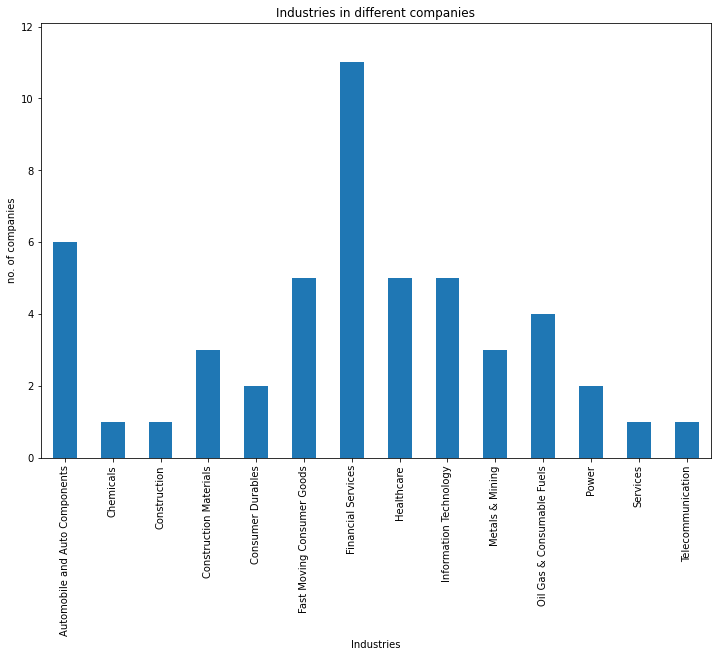

In [9]:
# plot
%matplotlib inline
ax = df_stocks_seg.plot(kind='bar', figsize=(12, 8), title='Industries in different companies',
             xlabel='Industries', ylabel='no. of companies', legend=False)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [ ]:
len(df_stocks)

50

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.axis('equal')
# Industry = ['Automobile and Auto Components', 'Chemicals', 'Construction', 'Construction Materials',  'Consumer Durables', 
#             'Fast Moving Consumer Goods', 'Fast Moving Consumer Goods', 'Healthcare', 'Information Technology', 'Metals & Mining', 
#             'Oil Gas & Consumable Fuels', 'Power', 'Services']
# ax.pie(len(df_stocks.groupby(by = ['Industry']).count())/labels = Industry, autopct='%1.2f%%')
# plt.show()

ANALYSIS USING DEEP REINFORCEMENT LEARNING

In [14]:
df_stocks['Symbol'] = df_stocks['Symbol'].astype(str) + '.NS'

In [15]:
stocks_list = df_stocks['Symbol'].tolist()

In [16]:
start_date = '2014-01-01'
end_date = '2021-12-01'

df_NSE = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = stocks_list).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
""" Perform Feature Engineering """
df_NSE = FeatureEngineer(use_technical_indicator=True,
                                      tech_indicator_list = config.INDICATORS,
                                      use_turbulence=True,
                                      user_defined_feature = False).preprocess_data(df_NSE.copy())

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
df_NSE.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')

In [ ]:
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426819,851727,ADANIPORTS.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,150.426819,150.426819,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716614,335988,APOLLOHOSP.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,938.716614,938.716614,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825500,1866326,ASIANPAINT.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,471.825500,471.825500,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,248.631042,248.631042,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,1560.954224,1560.954224,0.0


In [ ]:
df_NSE['close'].groupby(df_NSE['tic']).mean()

tic
ADANIPORTS.NS     359.620345
APOLLOHOSP.NS    1547.908140
ASIANPAINT.NS    1340.821982
AXISBANK.NS       547.310524
BAJAJ-AUTO.NS    2530.525629
                    ...     
TECHM.NS          599.818807
TITAN.NS          796.532041
ULTRACEMCO.NS    3904.574746
UPL.NS            432.897489
WIPRO.NS          255.302200
Name: close, Length: 48, dtype: float64

In [10]:
# imports
!pip install yfinance
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd

In [17]:
SBIN_df = yf.download('SBIN.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [36]:
SBIN_df.head()

,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,
2014-01-01,177.199997,177.490005,176.125000,176.505005,166.483276,5904780,NaN,NaN,NaN,NaN
2014-01-02,176.589996,180.600006,173.220001,174.259995,164.365738,19451900,NaN,NaN,NaN,-0.012719
2014-01-03,172.699997,173.600006,171.100006,171.964996,162.201035,13759590,NaN,NaN,NaN,-0.013170
2014-01-06,172.190002,172.399994,168.199997,168.815002,159.229889,13907830,NaN,NaN,NaN,-0.018318
2014-01-07,169.289993,170.199997,165.500000,166.139999,156.706787,17352910,NaN,NaN,NaN,-0.015846


In [28]:
YESBANK_df = yf.download('YESBANK.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [30]:
ASIANPAINT_df = yf.download('ASIANPAINT.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [32]:
APOLLOHOSP_df = yf.download('APOLLOHOSP.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [18]:
#moving average for stocks over a 10, 20 and 50 day period of time.
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    SBIN_df[column_name] = SBIN_df['Adj Close'].rolling(window=ma,center=False).mean()

SBIN_df.tail()  

,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,
2021-11-24,495.799988,500.000000,489.049988,493.149994,493.149994,13963769,502.154999,510.232504,482.358004
2021-11-25,490.000000,495.450012,486.299988,490.549988,490.549988,12894211,498.769995,509.132504,483.512003
2021-11-26,486.250000,487.899994,467.100006,470.500000,470.500000,26305817,494.859995,506.700003,484.262003
2021-11-29,470.000000,477.750000,454.299988,465.100006,465.100006,22407465,490.234995,504.887503,484.687003
2021-11-30,468.000000,477.250000,458.000000,460.549988,460.549988,23026652,485.634995,502.807503,484.624003


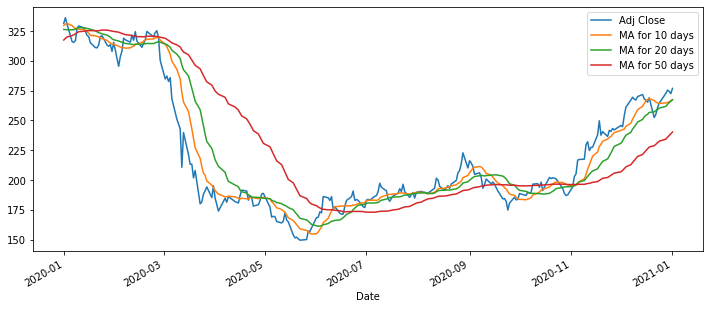

In [19]:
SBIN_df.truncate(before='2020-01-01', after='2021-01-01')[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False,figsize=(12,5))

In [ ]:
# plt.figure(figsize=(24,20))
# plt.bar(df_NSE['tic'], df_NSE['close'].mean())
# plt.tight_layout()
# plt.show()

Moving averages are used to identify significant support and resistance levels.
Traders watch for crossovers of longer-term moving averages by shorter-term moving averages as possible indicators of trend changes to enter long and short positions.
According to Stan Weinstein: The price must be above the short term MA in order to buy a stock.

In [20]:
# The daily return column can be created by using the percentage change over the adjusted closing price
SBIN_df['Daily Return'] = SBIN_df['Adj Close'].pct_change()

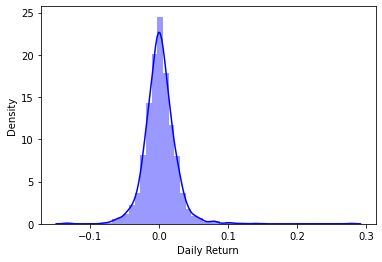

In [23]:
#univariant distribution
#Positive daily returns seem to be slightly less frequent than negative returns for SBIN.
sns.distplot(SBIN_df['Daily Return'].dropna(),bins=50,color='blue')

In [44]:
df_NSE.head()

,date,open,high,low,close,volume,tic,day
0,2014-01-01,154.550003,157.750000,154.550003,150.426819,851727,ADANIPORTS.NS,2
1,2014-01-01,940.250000,987.650024,940.250000,938.716553,335988,APOLLOHOSP.NS,2
2,2014-01-01,494.399994,503.899994,492.000000,471.825470,1866326,ASIANPAINT.NS,2
3,2014-01-01,260.299988,261.000000,257.640015,248.631058,2849425,AXISBANK.NS,2
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2


In [46]:
# df = df_NSE.reset_index()
# df = df_NSE[['date', 'close', 'tic']]
# df.head()
df_pivot=df_NSE.fillna(0).pivot('date','tic','close').reset_index()
df_pivot.head()

tic,date,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
0,2014-01-01,150.426819,938.716553,471.825470,248.631058,1560.954224,755.766113,153.205643,296.388519,72.927994,...,543.980469,143.735397,369.242859,338.857880,912.958679,382.834534,220.011139,1725.381470,121.793694,192.681702
1,2014-01-02,146.913986,901.189331,458.418976,244.802124,1546.829468,724.197021,153.098312,288.446838,70.891769,...,545.406189,138.765121,366.682404,333.527130,918.767212,380.321533,215.769165,1688.177368,120.873123,192.768845
2,2014-01-03,144.267303,921.914001,462.148285,242.608612,1543.166016,725.141724,151.761688,289.017242,68.772018,...,550.966248,140.018860,357.179291,328.196472,942.170837,384.384216,216.770081,1684.374268,122.806343,194.041336
3,2014-01-06,145.181610,915.861328,463.233978,241.723557,1537.263794,727.527954,151.366531,289.017242,68.876450,...,559.092407,140.421875,361.364594,324.854828,949.548218,380.269257,217.151413,1681.546021,123.634903,194.529388
4,2014-01-07,140.465729,902.690308,462.573120,237.480942,1538.607178,726.881714,151.620193,291.079468,67.571167,...,564.747498,140.153183,359.542755,314.034271,935.366028,377.798126,215.483185,1648.291504,123.819000,191.810135


In [47]:
#Combined Dataframe of all stocks
#Now, we can run the correlation. 
#Using the Pandas ‘corr’ function to compute the Pearson correlation coeffecient between each pair of equities.
corr_df = df_pivot.corr(method='pearson')
# reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
# del corr_df.index.name
corr_df.head(10)

tic,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
tic,,,,,,,,,,,,,,,,,,,,,
ADANIPORTS.NS,1.000000,0.849268,0.872543,0.719683,0.885611,0.870748,0.862481,0.762556,0.722518,0.726075,...,-0.041433,0.874715,-0.167879,0.889584,0.857000,0.848626,0.856302,0.935618,0.808541,0.890784
APOLLOHOSP.NS,0.849268,1.000000,0.877082,0.546537,0.773981,0.814401,0.826532,0.794595,0.556664,0.606605,...,0.180720,0.899065,-0.097592,0.830339,0.849801,0.899606,0.805853,0.866390,0.638554,0.958995
ASIANPAINT.NS,0.872543,0.877082,1.000000,0.685731,0.920497,0.935504,0.969881,0.845679,0.786276,0.882123,...,-0.206534,0.955645,-0.442281,0.791143,0.966023,0.894381,0.948786,0.928917,0.809901,0.890986
AXISBANK.NS,0.719683,0.546537,0.685731,1.000000,0.723416,0.779929,0.759257,0.455322,0.680443,0.686539,...,-0.200409,0.553002,-0.317649,0.571431,0.693348,0.692507,0.745049,0.755640,0.828983,0.611857
BAJAJ-AUTO.NS,0.885611,0.773981,0.920497,0.723416,1.000000,0.891810,0.904060,0.782696,0.881193,0.849083,...,-0.243842,0.874377,-0.322339,0.799491,0.870593,0.778345,0.875818,0.939758,0.873819,0.807468
BAJAJFINSV.NS,0.870748,0.814401,0.935504,0.779929,0.891810,1.000000,0.978771,0.781427,0.816443,0.865893,...,-0.304872,0.882840,-0.433659,0.834205,0.918040,0.892387,0.967862,0.931031,0.875931,0.857258
BAJFINANCE.NS,0.862481,0.826532,0.969881,0.759257,0.904060,0.978771,1.000000,0.812455,0.793724,0.892251,...,-0.312829,0.923376,-0.503408,0.787750,0.963931,0.903558,0.979126,0.917276,0.838449,0.867738
BHARTIARTL.NS,0.762556,0.794595,0.845679,0.455322,0.782696,0.781427,0.812455,1.000000,0.671894,0.717889,...,-0.084055,0.898395,-0.304065,0.688934,0.813752,0.768882,0.815143,0.777095,0.595759,0.773772
BPCL.NS,0.722518,0.556664,0.786276,0.680443,0.881193,0.816443,0.793724,0.671894,1.000000,0.822453,...,-0.418476,0.684985,-0.363751,0.619089,0.680321,0.559997,0.758249,0.827748,0.894087,0.557410


<Figure size 432x288 with 0 Axes>

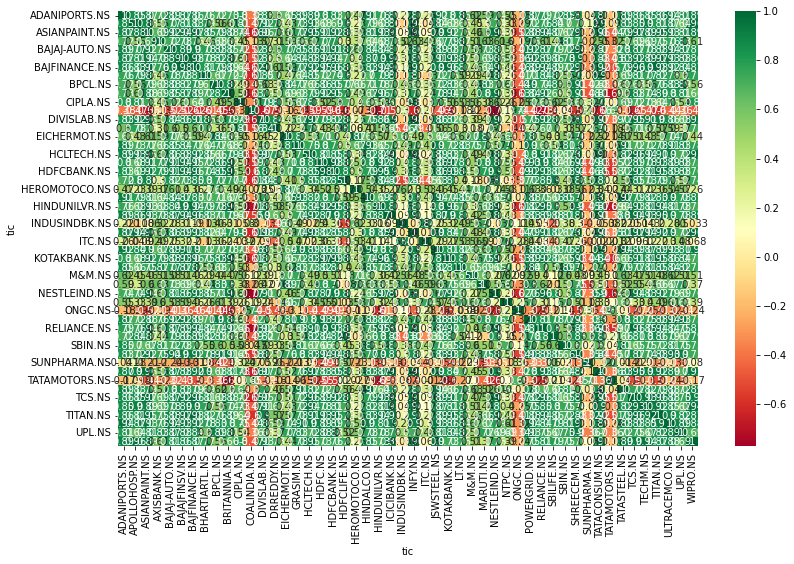

<Figure size 432x288 with 0 Axes>

In [48]:
#Correlation values between the stocks
#Now let’s use Seaborn library to plot a heatmap 
#and visualise the correlations in a better way
plt.figure(figsize=(13, 8))
sns.heatmap(corr_df, annot=True, cmap="RdYlGn")
plt.figure()

Text(0, 0.5, 'Price')

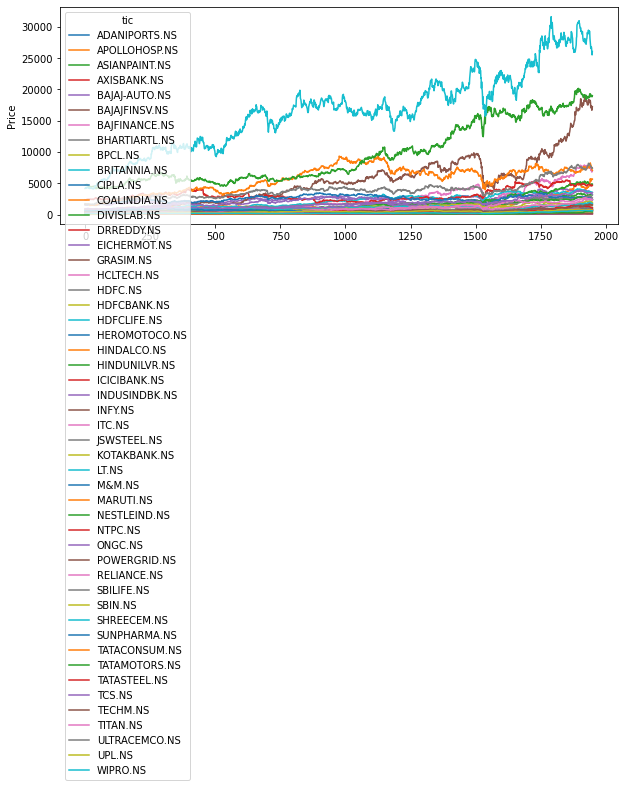

In [49]:
# return of various stocks?
df_pivot.plot(figsize=(10,4))
plt.ylabel('Price')

In [57]:
df_pivot.head()

tic,date,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
0,2014-01-01,150.426819,938.716553,471.825470,248.631058,1560.954224,755.766113,153.205643,296.388519,72.927994,...,543.980469,143.735397,369.242859,338.857880,912.958679,382.834534,220.011139,1725.381470,121.793694,192.681702
1,2014-01-02,146.913986,901.189331,458.418976,244.802124,1546.829468,724.197021,153.098312,288.446838,70.891769,...,545.406189,138.765121,366.682404,333.527130,918.767212,380.321533,215.769165,1688.177368,120.873123,192.768845
2,2014-01-03,144.267303,921.914001,462.148285,242.608612,1543.166016,725.141724,151.761688,289.017242,68.772018,...,550.966248,140.018860,357.179291,328.196472,942.170837,384.384216,216.770081,1684.374268,122.806343,194.041336
3,2014-01-06,145.181610,915.861328,463.233978,241.723557,1537.263794,727.527954,151.366531,289.017242,68.876450,...,559.092407,140.421875,361.364594,324.854828,949.548218,380.269257,217.151413,1681.546021,123.634903,194.529388
4,2014-01-07,140.465729,902.690308,462.573120,237.480942,1538.607178,726.881714,151.620193,291.079468,67.571167,...,564.747498,140.153183,359.542755,314.034271,935.366028,377.798126,215.483185,1648.291504,123.819000,191.810135


In [62]:
df_pivot = df_pivot.drop('tic')

TypeError: ignored

In [56]:
#Price plot for all the stock for the year 2020
#Normalising Multiple Stocks
returnfstart = df_pivot.apply(lambda x: int(x) / int(x[0]))
returnfstart.plot(figsize=(10,4)).axhline(1, lw=1, color='black')
plt.ylabel('Return From Start Price')

TypeError: ignored

In [51]:

#In this instance, I divided all the closing price to the first closing price in the period.

#Return From Start Price
#Daily return percentage Plot
df2=df_pivot.pct_change()
df2.plot(figsize=(10,4))
plt.axhline(0, color='black', lw=1)
plt.ylabel('Daily Percentage Return')

TypeError: ignored

In [53]:
#Daily Percentage Return
#Because I have 5stocks overlapping each other, it is a little hard to make any comparisons here.
#How much value do we put at risk by investing in a particular stock?
#A basic way to quantify risk is to compare the expected return (which can be the mean of the stock’s daily returns) with the standard deviation of the daily returns.
risk = corr_df.dropna()

In [55]:
#The 0.05 empirical quantile of daily returns is at 0.08604035320162473. 
#This means that with 95% confidence, the worst daily loss will not exceed 8.60% (of the investment).
risk['SBIN.NS'].quantile(0.05)

0.08604035320162473

**STOCK PRICE PREDICTION USING ARIMA**

In [ ]:
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
print(df_NSE.shape)
print(df_NSE.columns)

(93552, 17)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')


In [ ]:
df_NSE.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
turbulence      0
dtype: int64

In [ ]:
df_NSE['date'] = pd.to_datetime(df_NSE['date'])
df_NSE.set_index('date')
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426804,851727,ADANIPORTS.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,150.426804,150.426804,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716553,335988,APOLLOHOSP.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,938.716553,938.716553,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825470,1866326,ASIANPAINT.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,471.825470,471.825470,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,248.631042,248.631042,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954102,90587,BAJAJ-AUTO.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,1560.954102,1560.954102,0.0


In [ ]:
type(df_NSE)

pandas.core.frame.DataFrame

In [ ]:
df_NSE['date'][::-1]

93551   2021-11-30
93550   2021-11-30
93549   2021-11-30
93548   2021-11-30
93547   2021-11-30
           ...    
4       2014-01-01
3       2014-01-01
2       2014-01-01
1       2014-01-01
0       2014-01-01
Name: date, Length: 93552, dtype: datetime64[ns]

In [ ]:
tictic = df_NSE['close'].loc[df_NSE['tic'] == 'ASIANPAINT.NS']

In [ ]:
print(tictic)

2         471.825562
50        458.418945
98        462.148224
146       463.234039
194       462.573151
            ...     
93314    3157.000000
93362    3144.250000
93410    3143.100098
93458    3144.300049
93506    3143.649902
Name: close, Length: 1949, dtype: float64


In [ ]:
plt.figure(figsize=(60,44))
plt.plot(tictic)
plt.title('Closing Values')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.xticks(np.arange(100,5000, 500), df_NSE['date'][100:5000:500])
plt.tight_layout()
plt.show()

In [ ]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_NSE.close, autolag='AIC', maxlag = 20)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.01:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -45.328338
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    93531.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64


The stock price series of Asian Paints is stationary and reflects a random walk model (similar to a drunk man!) 



Text(0.5, 1.0, ' Autocorrelation plot of Asian Paints stock')

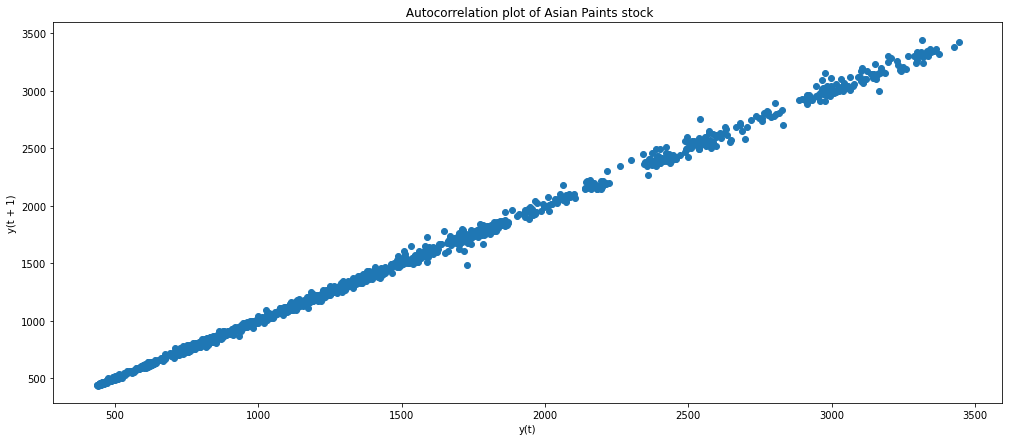

In [ ]:
# plt.figure(figsize=(17,7))
# lag_plot(tictic, lag=1)
# plt.title(' Autocorrelation plot of Asian Paints stock')

In [ ]:
# 12 month simple moving average and standard deviation
df['Production'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df1['Production'].rolling(12).std().plot(label='12 STD')
df1['Production'].plot()   # YOUR CODE HERE to plot 'Production' series
plt.legend()

Divide the data into train, test and split

In [ ]:
train_data, test_data = df_NSE[0:int(len(df_NSE)*0.8)], df_NSE[int(len(df_NSE)*0.8):]

In [ ]:
plt.figure(figsize=(17,7))
plt.title("Prices of Asian Paint stock")
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.plot(train_data['close'], 'blue', label = "Training Data")
plt.plot(test_data['close'], 'red', label = "Test Data")
plt.legend()
plt.show()

Plotting ACF and PACF plots to check ARIMA model order

In [ ]:
fig = plt.figure(fgsize=(15,7))
ax1 = fig.subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, )